In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools # for CIPS
import time

from IPython.display import display, HTML

# Set max-height to 'none' to prevent scrollbar
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

## Generate demand points with different distributions

In [2]:
# generate m random demand points
def generate_random_demand_points(m, x_range=(0, 1), y_range=(0, 1)):
    """
    Generate demand points using uniform distribution in a given range.
    
    :param m: Number of demand points
    :param x_range: Range for x-coordinate
    :param y_range: Range for y-coordinate
    :return: Array of generated demand points
    """
    x_coords = np.random.uniform(x_range[0], x_range[1], m)
    y_coords = np.random.uniform(y_range[0], y_range[1], m)
    return np.vstack((x_coords, y_coords)).T


# Generate random demand points using normal (Gaussian) distribution
def generate_random_demand_points_normal(m, x_mean=0.5, y_mean=0.5, x_std=0.2, y_std=0.2):
    """
    Generate demand points using Normal distribution, points are concentrated around the mean.
    
    :param m: Number of demand points
    :param x_mean: Mean value for x-coordinate
    :param y_mean: Mean value for y-coordinate
    :param x_std: Standard deviation for x-coordinate
    :param y_std: Standard deviation for y-coordinate
    :return: Array of generated demand points
    """
    x_coords = np.random.normal(x_mean, x_std, m)
    y_coords = np.random.normal(y_mean, y_std, m)
    # Make sure the points within the [0, 1] 
    x_coords = np.clip(x_coords, 0, 1)
    y_coords = np.clip(y_coords, 0, 1)
    return np.vstack((x_coords, y_coords)).T


# Generate random demand points using bimodal (two peaks) distribution
def generate_random_demand_points_bimodal(m, center1=(0.3, 0.3), center2=(0.7, 0.7), std=0.1):
    """
    Generate demand points using a bimodal distribution (two centers).
    
    :param m: Number of demand points
    :param center1: Coordinates of the first center
    :param center2: Coordinates of the second center
    :param std: Standard deviation for both centers
    :return: Array of generated demand points
    """
    m1 = m // 2  # Half points around the first center
    m2 = m - m1  # Remaining points around the second center
    # Generate points around the first center
    x_coords1 = np.random.normal(center1[0], std, m1)
    y_coords1 = np.random.normal(center1[1], std, m1)
    # Generate points around the second center
    x_coords2 = np.random.normal(center2[0], std, m2)
    y_coords2 = np.random.normal(center2[1], std, m2)
    
    x_coords = np.concatenate((x_coords1, x_coords2))
    y_coords = np.concatenate((y_coords1, y_coords2))
    
    # Ensure the points stay within the [0, 1] range
    x_coords = np.clip(x_coords, 0, 1)
    y_coords = np.clip(y_coords, 0, 1)
    return np.vstack((x_coords, y_coords)).T


### CIPS method to generate CLS

In [3]:
# Calculate intersection points of two circles
def circle_intersections(p1, p2, r):
    d = np.linalg.norm(p1 - p2)
    if d > 2 * r or d == 0:
        return np.empty((0, 2))  # No intersection or concentric circles
    a = (r**2 - r**2 + d**2) / (2 * d)
    h = np.sqrt(r**2 - a**2)
    mid_point = p1 + a * (p2 - p1) / d
    intersection1 = mid_point + h * np.array([-(p2[1] - p1[1]), p2[0] - p1[0]]) / d
    intersection2 = mid_point - h * np.array([-(p2[1] - p1[1]), p2[0] - p1[0]]) / d
    return np.array([intersection1, intersection2])

# Generate circle intersection point set (CIPS)
def generate_cips(demand_points, coverage_radius):
    intersections = []
    for (p1, p2) in itertools.combinations(demand_points, 2):
        intersections.append(circle_intersections(np.array(p1), np.array(p2), coverage_radius))
    
    if intersections:
        all_intersections = np.vstack(intersections)  # Combine all intersections into a single array
        unique_intersections = np.unique(all_intersections, axis=0)  # Remove duplicate points
        return unique_intersections
    else:
        return np.empty((0, 2))  # Return an empty array if no intersections are found

# Check if p2 is dominated by p1
def is_dominated(p1, p2, demand_points, coverage_radius):
    covered_by_p1 = set([tuple(dp) for dp in demand_points if np.linalg.norm(dp - p1) <= coverage_radius])
    covered_by_p2 = set([tuple(dp) for dp in demand_points if np.linalg.norm(dp - p2) <= coverage_radius])
    return covered_by_p2.issubset(covered_by_p1) and len(covered_by_p1) >= len(covered_by_p2)

# Remove dominated points from CIPS to get the final candidate location set (CLS)
def remove_dominated_points(cips, demand_points, coverage_radius):
    cls = list(map(tuple, cips.copy()))  # Convert numpy array to list of tuples
    total_comparisons = len(cips) * (len(cips) - 1) // 2  # Total possible comparisons
    comparison_count = 0

    for i, p1 in enumerate(cls):
        for j, p2 in enumerate(cls):
            if p1 != p2 and p2 in cls:
                comparison_count += 1
                if is_dominated(np.array(p1), np.array(p2), demand_points, coverage_radius):
                    cls.remove(p2)
            if comparison_count % 5000 == 0:  # Print progress every 5000 comparisons
                print(f"Progress: {comparison_count}/{total_comparisons} comparisons made")

    return np.array(cls)  # Convert back to numpy array for consistency

### GBH method to generate inital CLS

In [4]:
# Round demand points to the nearest grid points
def round_to_grid(demand_points, grid_size):
    """
    Round demand points to the nearest grid center instead of the grid intersection points.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param grid_size: Size of the grid (e.g., sqrt(2) * coverage_radius or user-defined)
    :return: Array of rounded grid points centered in each grid cell
    """
    # Shift the points by half a grid size before rounding to move them to grid centers
    return np.round((demand_points + grid_size / 2) / grid_size) * grid_size - grid_size / 2

# Expand grid points by shifting them in four directions
def expand_grid_points(grid_points, radius, shift_ratio=0.5):
    """
    Expand the grid points by shifting them in four directions: up-left, up-right, down-left, down-right.
    
    :param grid_points: Array of grid point coordinates (x, y)
    :param radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius (default is 1/2)
    :return: Array of expanded candidate points, including the original grid points and the shifted ones
    """
    expanded_points = []
    shifts = [(shift_ratio * radius, shift_ratio * radius), 
              (-shift_ratio * radius, shift_ratio * radius), 
              (shift_ratio * radius, -shift_ratio * radius), 
              (-shift_ratio * radius, -shift_ratio * radius)]
    
    for point in grid_points:
        expanded_points.append(point)  # Add the original grid point
        for shift in shifts:
            expanded_points.append(point + np.array(shift))  # Add the shifted point (original point + shift)
    
    return np.array(expanded_points)


# Generate Candidate Location Set (CLS) using GBH algorithm
def generate_cls(demand_points, coverage_radius, shift_ratio=0.5, grid_size=None):
    """
    Generate the Candidate Location Set (CLS) using the GBH algorithm.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param shift_ratio: Ratio of the shift relative to the radius
    :return: Array of candidate points (CLS)
    """
    
    if grid_size is None:
        grid_size = np.sqrt(2) * coverage_radius  # Default value
        
    rounded_points = round_to_grid(demand_points, grid_size)
    expanded_candidates = expand_grid_points(rounded_points, coverage_radius, shift_ratio)
    
    return expanded_candidates

### Filtering the generated CLS

In [5]:
# Function to calculate covered demand points for a given candidate
def calculate_covered(demand_points, candidate, radius):
    """
    Calculate which demand points are covered by the given candidate point.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate: Candidate point coordinates (x, y)
    :param radius: Coverage radius
    :return: Array of covered demand points
    """
    distances = np.linalg.norm(demand_points - candidate, axis=1)
    return demand_points[distances <= radius]


# Function to filter candidate points that do not cover any demand points or are out of bounds
def filter_candidate_points(demand_points, candidate_points, coverage_radius, bounds=(0, 1)):
    """
    Filter out candidate points that do not cover any demand points or are out of bounds.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param bounds: A tuple representing the (min, max) bounds for both x and y coordinates
    :return: Filtered array of candidate points that cover at least one demand point and are within bounds
    """
    filtered_candidates = []
    
    min_bound, max_bound = bounds  # Unpack bounds
    
    for candidate in candidate_points:
        # Check if the candidate is within the specified bounds
        if np.all(candidate >= min_bound) and np.all(candidate <= max_bound):
            covered_points = calculate_covered(demand_points, candidate, coverage_radius)
            if len(covered_points) > 0:  # Keep candidates that cover at least one demand point
                filtered_candidates.append(candidate)
    
    return np.array(filtered_candidates)

# Function to calculate discounted coverage for each candidate
def calculate_discounted_coverage(demand_points, candidate_points, coverage_radius):
    """
    Calculate the discounted coverage for each candidate, where the contribution of a demand point is shared among 
    all candidates that cover it.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :return: List of tuples (candidate, discounted_coverage)
    """
    # Step 1: Initialize dictionaries to store the coverage of each demand point
    demand_coverage_count = {tuple(dp): 0 for dp in demand_points}  # Tracks how many candidates cover each demand point
    candidate_coverage = {tuple(cp): 0 for cp in candidate_points}  # Tracks the discounted coverage of each candidate
    
    # Step 2: Calculate how many candidates cover each demand point
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            demand_coverage_count[tuple(dp)] += 1  # Increment the count for each demand point
    
    # Step 3: Calculate the discounted coverage for each candidate
    for candidate in candidate_points:
        covered_points = calculate_covered(demand_points, candidate, coverage_radius)
        for dp in covered_points:
            # Discount the coverage contribution by the number of candidates covering this demand point
            candidate_coverage[tuple(candidate)] += 1 / demand_coverage_count[tuple(dp)]
    
    # Step 4: Convert the dictionary to a list of tuples for sorting
    return [(candidate, candidate_coverage[tuple(candidate)]) for candidate in candidate_points]

# Function to remove the least effective candidate points based on discounted coverage
def remove_least_effective_candidates_with_discount(demand_points, candidate_points, coverage_radius, final_count):
    """
    Remove candidate points that have the least effective discounted coverage until only final_count candidates remain.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (x, y)
    :param coverage_radius: Radius of the coverage circle
    :param final_count: The number of final candidate points to retain
    :return: Array of remaining candidate points after removing the least effective ones
    """
    # Step 1: Calculate the discounted coverage for each candidate
    candidate_discounted_coverage = calculate_discounted_coverage(demand_points, candidate_points, coverage_radius)
    
    # Step 2: Sort candidates by their discounted coverage in ascending order
    candidate_discounted_coverage.sort(key=lambda x: x[1])  # Sort by discounted coverage (ascending)
    
    # Step 3: Keep the top candidates with the highest discounted coverage, discard the rest
    # Keep only the top 'final_count' candidates
    remaining_candidates = [item[0] for item in candidate_discounted_coverage[-final_count:]]  
    
    return np.array(remaining_candidates)

### Plot the points and CLS

In [6]:
# Plot the demand points and candidate points (CLS)
def plot_points(demand_points, candidate_points):
    """
    Plot the demand points and candidate points (CLS).
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c='blue', label='Demand Points', s=10)
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=30, marker='x')
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points and Candidate Points (CLS)')
    plt.show()
     
    
def plot_points_with_grid(demand_points, candidate_points, grid_size):
    """
    Plot the demand points, candidate points (CLS), and draw grid lines.
    
    :param demand_points: Array of demand point coordinates (x, y)
    :param candidate_points: Array of candidate point coordinates (CLS)
    :param grid_size: Size of each grid square used in generating the candidate points
    """
    plt.figure(figsize=(8, 8))
    
    # Plot demand points as blue dots
    plt.scatter(demand_points[:, 0], demand_points[:, 1], c='blue', label='Demand Points', s=20, alpha=0.7)
    
    # Plot candidate points (CLS) as red Xs
    plt.scatter(candidate_points[:, 0], candidate_points[:, 1], c='red', label='Candidate Points (CLS)', s=40, marker='x')
    
    # Draw grid lines based on grid_size
    ticks = np.arange(0, 1 + grid_size, grid_size)
    plt.gca().set_xticks(ticks, minor=True)
    plt.gca().set_yticks(ticks, minor=True)
    plt.grid(which='minor', color='gray', linestyle='--', linewidth=0.5)  # Minor grid lines based on grid_size
    
    # Set x and y ticks to show from 0 to 1 with 0.2 interval, but without grid lines
    plt.xticks(np.arange(0, 1.1, 0.2))  # X-axis ticks from 0 to 1 with step 0.2
    plt.yticks(np.arange(0, 1.1, 0.2))  # Y-axis ticks from 0 to 1 with step 0.2
    
    # Remove major grid lines (only leave minor ones)
    plt.grid(which='major', linestyle='None')  # No grid lines for major ticks (0.2 intervals)
    
    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.title('Demand Points, Candidate Points (CLS) and Grid')
    plt.show()

### Data Initialization

In [7]:
# data
m = 100   # number of demand points
coverage_radius = 0.1  # number of demand points
np.random.seed(451)

### Uniform distribution  

CIPS: 1020
Progress: 0/519690 comparisons made
Progress: 5000/519690 comparisons made
Progress: 10000/519690 comparisons made
Progress: 15000/519690 comparisons made
Progress: 20000/519690 comparisons made
Progress: 25000/519690 comparisons made
Progress: 30000/519690 comparisons made
Progress: 35000/519690 comparisons made
Progress: 40000/519690 comparisons made
Progress: 45000/519690 comparisons made
Progress: 50000/519690 comparisons made
Progress: 55000/519690 comparisons made
Progress: 60000/519690 comparisons made
Progress: 65000/519690 comparisons made
Progress: 70000/519690 comparisons made
Progress: 75000/519690 comparisons made
Progress: 80000/519690 comparisons made
Progress: 85000/519690 comparisons made
Progress: 90000/519690 comparisons made
Progress: 95000/519690 comparisons made
Progress: 100000/519690 comparisons made
Progress: 105000/519690 comparisons made
Progress: 110000/519690 comparisons made
Progress: 115000/519690 comparisons made
Progress: 120000/519690 compar

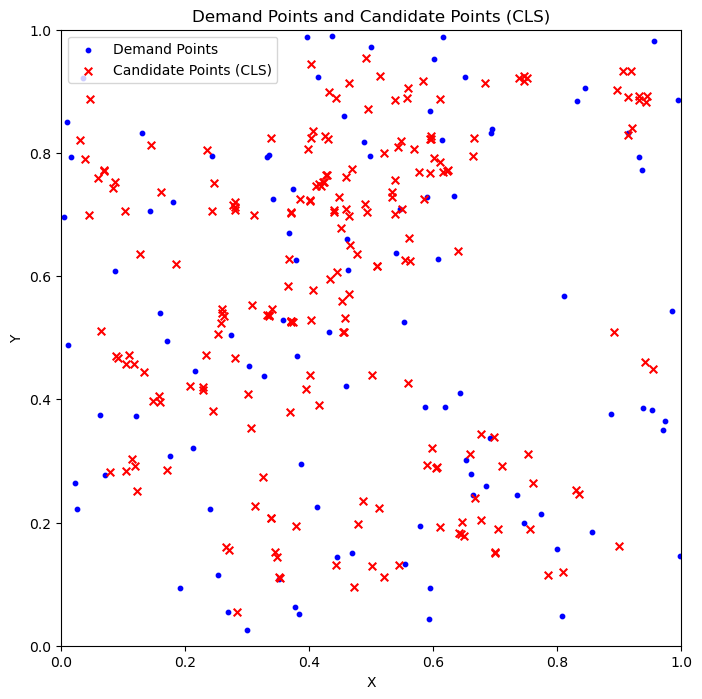

Total candidate points: 500
Unique candidate points: 215
Total candidate points after filtering: 202
Final CLS Remaining: 50


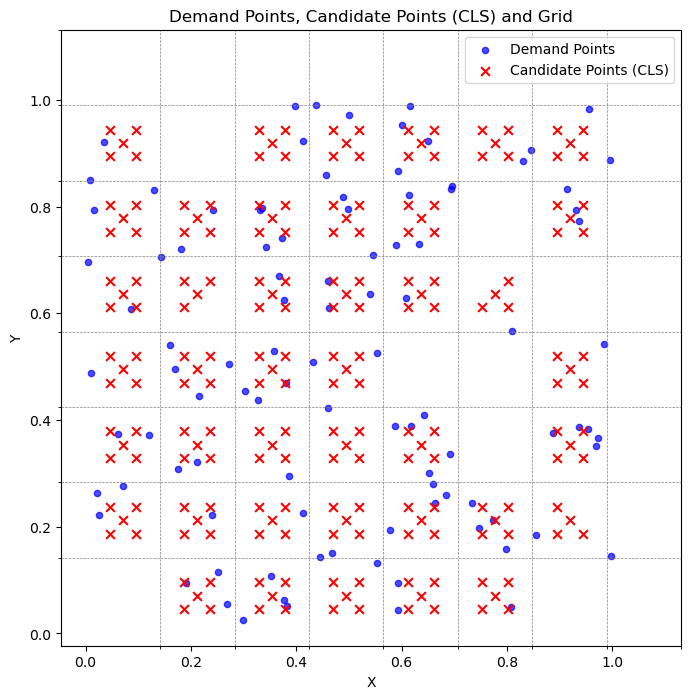

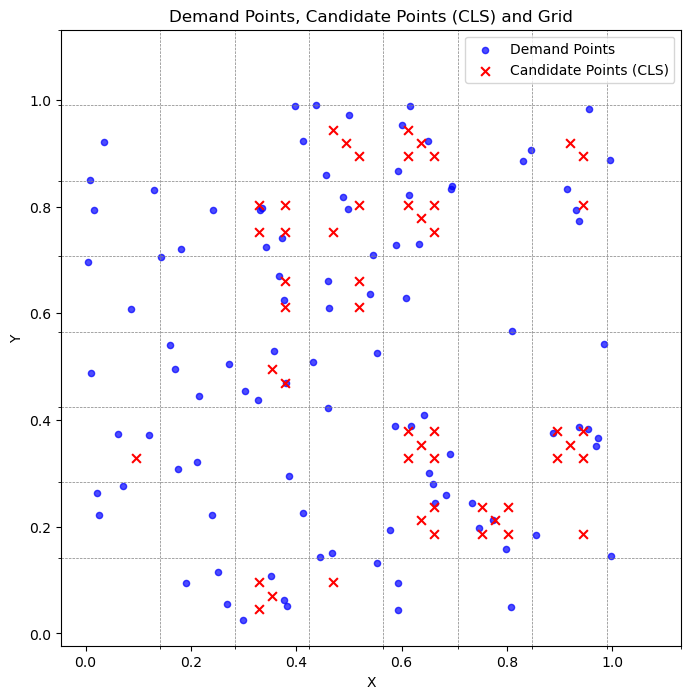

In [8]:
demand_points = generate_random_demand_points(m)  # Generating Uniform distribution demand points in the [0,1] range

## CIPS ####################################################################
start_time = time.time()
cips = generate_cips(demand_points, coverage_radius)
print(f"CIPS: {len(cips)}")
cips_cls = remove_dominated_points(cips, demand_points, coverage_radius)

end_time = time.time()
execution_time = end_time - start_time
minutes, seconds = divmod(execution_time, 60)
print(f"execution time: {int(minutes)} min {int(seconds)} secs")

print(f"CIPS After removing dominated points: {len(cips_cls)}")
plot_points(demand_points, cips_cls)

## GBH ####################################################################
shift_ratio = 0.25 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * coverage_radius

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_points, coverage_radius, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_points, unique_candidate_points, coverage_radius, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
n = 50  # Number of points to finally retain
remaining_candidates = remove_least_effective_candidates_with_discount(demand_points, filtered_candidate_points, \
                                                                       coverage_radius, n)
# Print the result
print(f"Final CLS Remaining: {len(remaining_candidates)}")
plot_points_with_grid(demand_points, filtered_candidate_points, grid_size)

# Plot the final result
plot_points_with_grid(demand_points, remaining_candidates, grid_size)

### Normal distribution

CIPS: 2232
Progress: 0/2489796 comparisons made
Progress: 5000/2489796 comparisons made
Progress: 10000/2489796 comparisons made
Progress: 15000/2489796 comparisons made
Progress: 20000/2489796 comparisons made
Progress: 25000/2489796 comparisons made
Progress: 30000/2489796 comparisons made
Progress: 35000/2489796 comparisons made
Progress: 40000/2489796 comparisons made
Progress: 45000/2489796 comparisons made
Progress: 50000/2489796 comparisons made
Progress: 55000/2489796 comparisons made
Progress: 60000/2489796 comparisons made
Progress: 65000/2489796 comparisons made
Progress: 70000/2489796 comparisons made
Progress: 75000/2489796 comparisons made
Progress: 80000/2489796 comparisons made
Progress: 85000/2489796 comparisons made
Progress: 90000/2489796 comparisons made
Progress: 95000/2489796 comparisons made
Progress: 100000/2489796 comparisons made
Progress: 105000/2489796 comparisons made
Progress: 110000/2489796 comparisons made
Progress: 115000/2489796 comparisons made
Progre

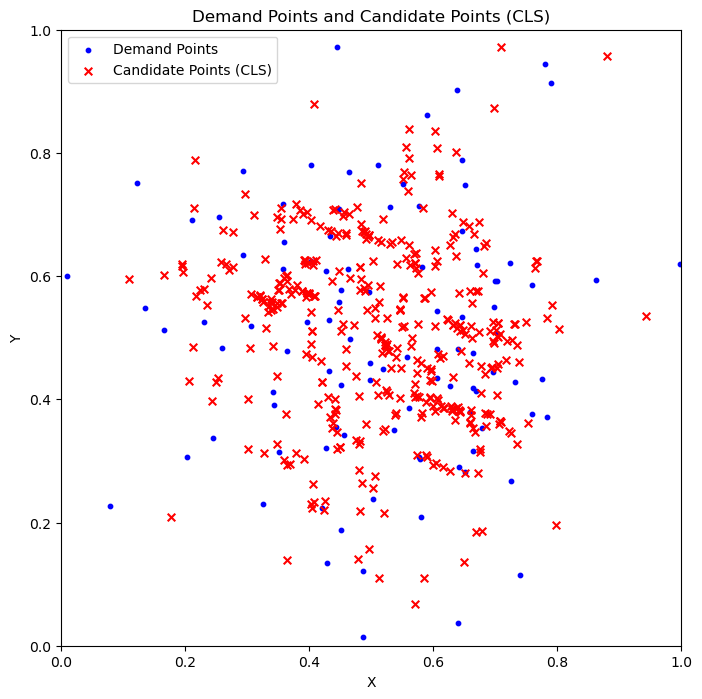

Total candidate points: 500
Unique candidate points: 170
Total candidate points after filtering: 164
Final CLS Remaining: 50


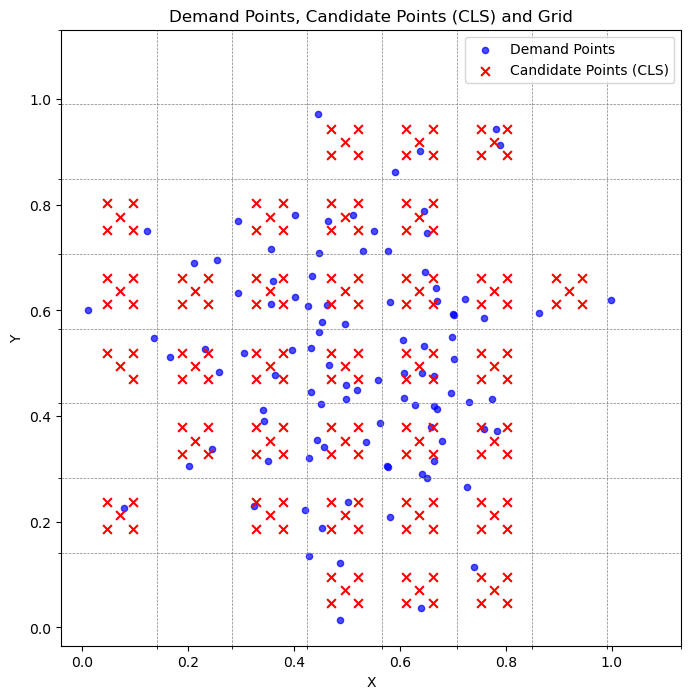

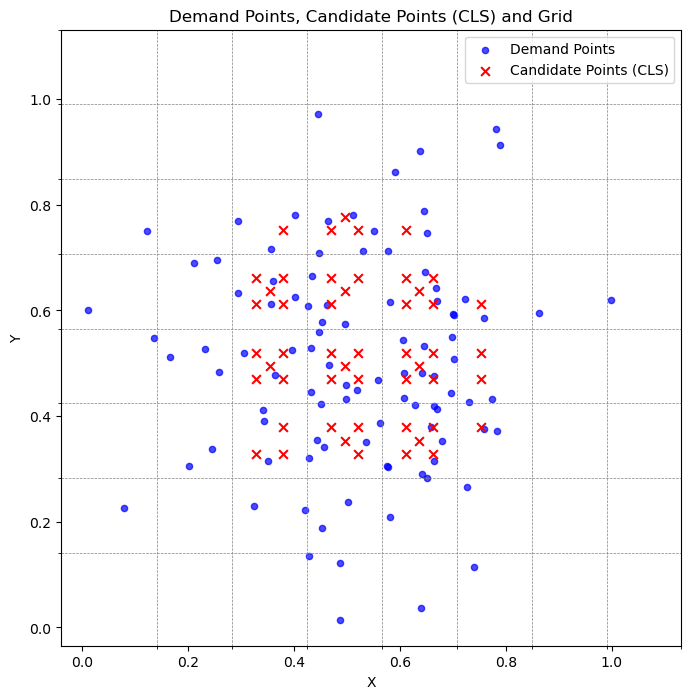

In [9]:
# Generate random demand points (for the example)
demand_points = generate_random_demand_points_normal(m)  # Generating random demand points in the [0,1] range

## CIPS ####################################################################
start_time = time.time()
cips = generate_cips(demand_points, coverage_radius)
print(f"CIPS: {len(cips)}")
cips_cls = remove_dominated_points(cips, demand_points, coverage_radius)

end_time = time.time()
execution_time = end_time - start_time
minutes, seconds = divmod(execution_time, 60)
print(f"execution time: {int(minutes)} min {int(seconds)} secs")

print(f"CIPS After removing dominated points: {len(cips_cls)}")
plot_points(demand_points, cips_cls)

## GBH ####################################################################
shift_ratio = 0.25 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * coverage_radius

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_points, coverage_radius, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_points, unique_candidate_points, coverage_radius, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
n = 50  # Number of points to finally retain
remaining_candidates = remove_least_effective_candidates_with_discount(demand_points, filtered_candidate_points, \
                                                                       coverage_radius, n)
# Print the result
print(f"Final CLS Remaining: {len(remaining_candidates)}")
plot_points_with_grid(demand_points, filtered_candidate_points, grid_size)

# Plot the final result
plot_points_with_grid(demand_points, remaining_candidates, grid_size)

### Bi-modal distribution

Total candidate points: 500
Unique candidate points: 120
Total candidate points after filtering: 112
execution time: 0 min 0 secs
Final CLS Remaining: 50


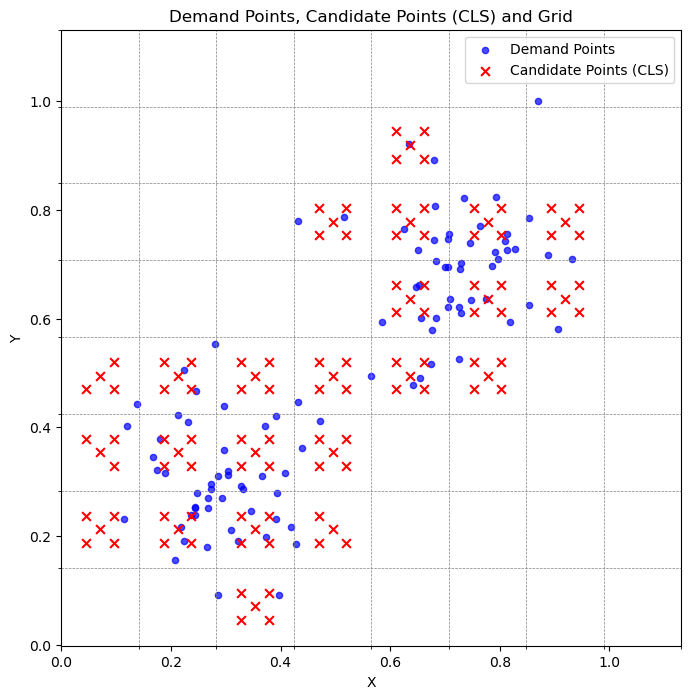

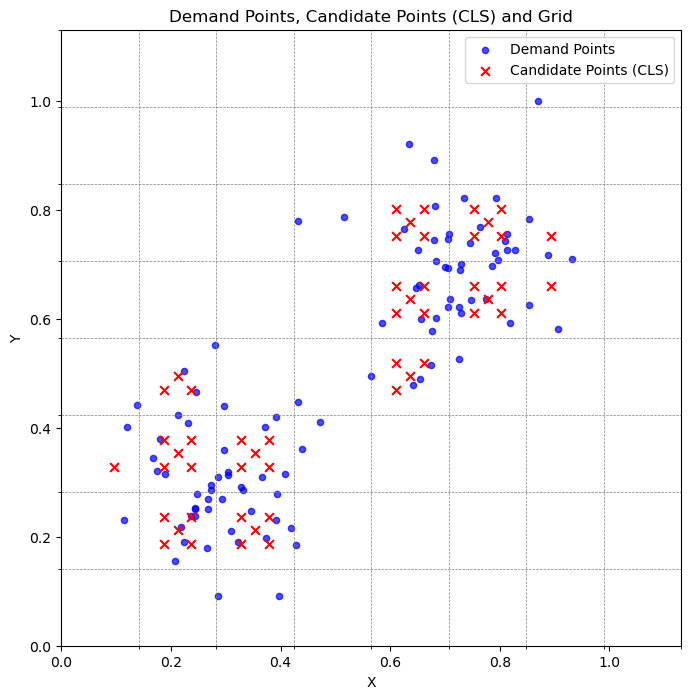

In [11]:
demand_points = generate_random_demand_points_bimodal(m)  # Generating random demand points in the [0,1] range

## CIPS ####################################################################
start_time = time.time()
cips = generate_cips(demand_points, coverage_radius)
print(f"CIPS: {len(cips)}")
cips_cls = remove_dominated_points(cips, demand_points, coverage_radius)

end_time = time.time()
execution_time = end_time - start_time
minutes, seconds = divmod(execution_time, 60)
print(f"execution time: {int(minutes)} min {int(seconds)} secs")

print(f"CIPS After removing dominated points: {len(cips_cls)}")
plot_points(demand_points, cips_cls)

## GBH ####################################################################
shift_ratio = 0.25 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * coverage_radius

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_points, coverage_radius, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_points, unique_candidate_points, coverage_radius, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
n = 50  # Number of points to finally retain
remaining_candidates = remove_least_effective_candidates_with_discount(demand_points, filtered_candidate_points, \
                                                                       coverage_radius, n)


# Print the result
print(f"Final CLS Remaining: {len(remaining_candidates)}")
plot_points_with_grid(demand_points, filtered_candidate_points, grid_size)

# Plot the final result
plot_points_with_grid(demand_points, remaining_candidates, grid_size)

### Beta distribution

In [ ]:
def generate_random_demand_points_beta(m, ax=2, bx=6, ay=2, by=6):
    """
    Generate demand points using beta distribution.
    
    :param m: Number of demand points
    :param a: Beta distribution parameter a
    :param b: Beta distribution parameter b
    :return: Array of generated demand points
    """
    x_coords = np.random.beta(ax, bx, m)
    y_coords = np.random.beta(ay, by, m)
    return np.vstack((x_coords, y_coords)).T

demand_points = generate_random_demand_points_beta(m)  # Generating random demand points in the [0,1] range

## CIPS ####################################################################
cips = generate_cips(demand_points, coverage_radius)
print(f"CIPS: {len(cips)}")
plot_points(demand_points, cips)


## GBH ####################################################################
shift_ratio = 0.25 # Set shift ratio (e.g., 1/4 or 1/2) 
bounds = (0, 1)  # Set bounds (can be adjusted as needed) Default range [0, 1] for both x and y
grid_size = np.sqrt(2) * coverage_radius

# Generate candidate points (from your previous GBH process)
candidate_points = generate_cls(demand_points, coverage_radius, shift_ratio=shift_ratio)

# check unique points
unique_candidate_points = np.unique(candidate_points, axis=0)
print(f"Total candidate points: {len(candidate_points)}")
print(f"Unique candidate points: {len(unique_candidate_points)}")

# Filter out candidate points that do not cover any demand points
filtered_candidate_points = filter_candidate_points(demand_points, unique_candidate_points, coverage_radius, bounds=bounds)
print(f"Total candidate points after filtering: {len(filtered_candidate_points)}")

# Remove least effective candidate points until only m candidates remain, considering discounted coverage
n = 50  # Number of points to finally retain
remaining_candidates = remove_least_effective_candidates_with_discount(demand_points, filtered_candidate_points, \
                                                                       coverage_radius, n)
# Print the result
print(f"Final CLS Remaining: {len(remaining_candidates)}")
plot_points_with_grid(demand_points, filtered_candidate_points, grid_size)

# Plot the final result
plot_points_with_grid(demand_points, remaining_candidates, grid_size)